# Abstract
Here I present implementation of pytorch neural networks for Pyroxene-Liquid thermobarometry. It took 25 chemical composition from mineral as the input,and pressure and temperature prediction as the output simultaneously. The current implementation yield pressure and temperature uncertainty of 0.7 GPa and 16 K, respectively.

# Introduction

P-T determination for magmatic process seems to be a never-ending topics in geochemistry. But the tools for that has not change much over the 20th and 21st centuries. 

Mineral assembly such P-T have been so far exploiting thermodynamics equilibria. Over the last two centuries, it had been defacto method. Over the decades terms have been added to update the model, and lots of effort have been gone through to validate them. The drawbacks with every model deviations and updates, more and more term are added, which makes the model becomes unwieldy complex. For example, the last update  pyroxene thermobarometry has more than 20 energy terms (Ghiorso Papers)

As machine learning become more common, we will find it in every application. Particularly in geology, where abundance of training data is available (LEPR). Surprisingly, there had not been much implementation of machine learning to P-T determination.


P-T determination for magmatic process seems to be a never-ending topics in geochemistry. But the tools for that has not change much over the 20th and 21st centuries. 

Mineral assembly such P-T have been so far exploiting thermodynamics equilibria, and hasn't change much. Terms have been added, and lots of attempt done to validate them.

Thermo barometer that considers the three phase of pyroxene has not been updated since Anderson and Lindsley in 1983.
Later MELT's based gave really different results.

Recent efforts for ML are by Pitrelli et. al in 2020.
From the same group: https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2020JB020130

Jorgansen 2021 https://www.google.com/url?sa=t&source=web&rct=j&url=https://eartharxiv.org/repository/object/2567/download/5230/&ved=2ahUKEwjputT1n431AhWxjuYKHUyrCEAQFnoECAUQAQ&usg=AOvVaw0EJvrihFpeRF9uMJ811AmS

In those two cases, it used random forest framework



Much more stuff going on with mineral - melts thermobarometry.

One tricky thing about P-T is that they are non-independent target. Gaussian process will have difficulty to model this. 

Neural Networks (NN) has more flexibility for this. However, getting prediction uncertainty in NN is rather tricky. Quantifying their uncertainty have been quite an interest

There is a review about NN uncertainty
https://arxiv.org/abs/2107.03342

Datasets
Recent Experiments Wang 2021 https://ejm.copernicus.org/articles/33/621/2021/



# Method

## Datasets Preparation
We obtain the training datasets from Library of Experimental Phase Relations
http://lepr.ofm-research.org/YUI/access_user/login.php

In this first atempt I am going to use Pyroxene - Melt datasets that have been compiled by Pitrelli et. al 2020 from supplementary file jgrb54402-sup-0002-2020jb020130-ts01.xlsx.

In those file it contains several spreadsheets i.e Table S1 to Table S2. 
In this case we are going to use Table S3 as Training/Validation Datasets, and Table S4 for Test.

Composition of melts and pyroxene are taken as inputs, which are 22 inputs. The output target is the Pressure and Temperature

Non-available cell quantity is filled with zero.


## Modeling
To quantify the model uncertainty, we construct ensemble of NN that has varying hyperparameters.

The neural network class is constructed as close as possible to scikit-learn workflow.
The class inherit from pytorch NN modules. 
Method fit an predict is incorporated in the nn object.
The predict method basically call to built in forward method.

Model's parameters that is the weight and bias were adjusted automatically by feeding the model with the mineral and melt compositions over multiple itteration that is epochs. Which we call training. During training, the training data were split further into training and validation portion in 10 folk cross validation.
The objective of the model training is to find the best parameters that results closest prediction. In this case the parameter optimization try to minimize the difference between the experiments results and the prediction given in mean square error (MSE). 

$MSE = \dfrac{1}{n} \Sigma_{i=1}^{n}\left(y_{true} - y_{pred}\right)^2$

In the current implementation, we use Adam optimizer and mean squared error as the loss function to minimize.

Hyper parameters optimization limit the number of hidden layers and nodes in the hidden layers to 30 layers and 300 nodes




# Results
Hyperparameters optimization gave out 10 unique structure of the neural networks. The simple structure are only one hidden layers with 100 nodes in the hidden layers. The largest structure are suggested are 5 hidden layers with 229 nodes in the hidden layers. For simplicity, here for layers with more than 20 nodes, we only draw 1 tenth the number of nodes.

<img src='figures/nn-summary.svg'>

Here we have the results of the modeling.
Temperature prediction seem pretty good with the $R^2$ 0.995 and 0.932 for the training data and test data respectively.
<img src='figures/results.svg'>

# Discussion

Neural network is really versatile. In a sense that vastly different neural network structurs able to gave a reasonable prediction.

## Limit to the method
- Use of significant computing power
In the current model I have use extra computing power provided by dedicated GPU, i.e trough pytorch package

The current method also required certain programming knowledge to implement it efficiently.

# Conclusions

# Refference

# Supplementary

## Codes

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import joblib
import datetime

import sklearn
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import skopt
from skopt import gp_minimize

import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, InputLayer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


time: 0 ns (started: 2021-12-31 17:03:31 +08:00)


In [153]:
today = datetime.date.today().isoformat()
plt.style.use('ggplot')

time: 0 ns (started: 2021-12-31 17:04:04 +08:00)


In [147]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 0 ns (started: 2021-12-31 16:57:10 +08:00)


### Prep Data

In [9]:
wb = pd.ExcelFile('pittrelli-2020-ts01.xlsx')

In [10]:
wb.sheet_names

['Table S1', 'Table S2', 'Table S3', 'Table S4']

In [233]:
df1 = wb.parse(sheet_name = 'Table S3', skiprows=1)
df2 = wb.parse(sheet_name = 'Table S4', skiprows=1)

time: 203 ms (started: 2021-12-31 18:06:02 +08:00)


In [52]:
features = list(df1)
targets = list(df1)[-2:]
features= list(df1)[1:-2]
features.remove('Unnamed: 13')
features.remove('Unnamed: 24')
#features.remove(''P_GPa')

In [53]:
features, targets

(['SiO2',
  'TiO2',
  'Al2O3',
  'FeOt',
  'MnO',
  'MgO',
  'CaO',
  'Na2O',
  'K2O',
  'Cr2O3',
  'P2O5',
  'H2O',
  'SiO2.1',
  'TiO2.1',
  'Al2O3.1',
  'FeOt.1',
  'MnO.1',
  'MgO.1',
  'CaO.1',
  'Na2O.1',
  'K2O.1',
  'Cr2O3.1'],
 ['P_GPa', 'T_K'])

In [78]:
X_train = df1[features].astype('float32')

In [234]:
X_test = df2[features].astype('float32')

time: 0 ns (started: 2021-12-31 18:06:26 +08:00)


In [79]:
X_train = X_train.fillna(0)

In [235]:
X_test = X_test.fillna(0)

time: 0 ns (started: 2021-12-31 18:06:49 +08:00)


In [236]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SiO2     119 non-null    float32
 1   TiO2     119 non-null    float32
 2   Al2O3    119 non-null    float32
 3   FeOt     119 non-null    float32
 4   MnO      119 non-null    float32
 5   MgO      119 non-null    float32
 6   CaO      119 non-null    float32
 7   Na2O     119 non-null    float32
 8   K2O      119 non-null    float32
 9   Cr2O3    119 non-null    float32
 10  P2O5     119 non-null    float32
 11  H2O      119 non-null    float32
 12  SiO2.1   119 non-null    float32
 13  TiO2.1   119 non-null    float32
 14  Al2O3.1  119 non-null    float32
 15  FeOt.1   119 non-null    float32
 16  MnO.1    119 non-null    float32
 17  MgO.1    119 non-null    float32
 18  CaO.1    119 non-null    float32
 19  Na2O.1   119 non-null    float32
 20  K2O.1    119 non-null    float32
 21  Cr2O3.1  119 non

In [81]:
y_train = df1[targets].astype('float32')

In [237]:
y_test = df2[targets].astype('float32')

time: 0 ns (started: 2021-12-31 18:07:11 +08:00)


### Scaler

In [83]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [239]:
X_test = scaler.transform(X_test)

time: 0 ns (started: 2021-12-31 18:08:24 +08:00)


In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Cuda Devices {}'.format(torch.cuda.get_device_name(torch.cuda.current_device())))

Using device: cuda
Cuda Devices NVIDIA GeForce RTX 3060 Laptop GPU


In [85]:
X_torch = Variable(torch.tensor(X_train, device=device))
y_torch = Variable(torch.tensor(np.asarray(y_train), device=device))

In [240]:
X_test_torch = Variable(torch.tensor(X_test, device=device))
y_test_torch = Variable(torch.tensor(np.asarray(y_test), device=device))

time: 0 ns (started: 2021-12-31 18:08:29 +08:00)


### Modeling

In [95]:
class Net(nn.Module):
    def __init__(self,n_input_nodes, n_hidden_layers, 
                 n_hidden_nodes, n_output_nodes ):
        """
        n_feature : number of input feature nodes
        n_hidden : number of nodes in the hidden layer
        n_output : number of nodes in the output layer
        
        d_hidden : number of hidden layers
        """
        
        super(Net, self).__init__() ## inherit init function from the ancestor
        
        
        self.input = nn.Linear(n_input_nodes, n_hidden_nodes)
        self.hidden = nn.Linear(n_hidden_nodes, n_hidden_nodes)
        self.output = nn.Linear(n_hidden_nodes, n_output_nodes)
        
        self.l_hidden = n_hidden_layers
        
    def forward(self, x):
        x = self.input(x)
        
        for i in range(self.l_hidden):
            x = self.hidden(x)
            x = F.relu(x)
        x = self.output(x)
        
        return x
    
    def predict(self, x):
        self.eval()
        return self.forward(x)
    
    def fit(self, train_x, train_y, epochs=100, verbose=True):
        """
        train_x : training x
        train_y : training y
        
        """
        self.train()
        
        optimizer = torch.optim.Adam(self.parameters()) ## SGD gave 'nan'
        loss_func = nn.MSELoss()

        n_splits = 10
        kf = KFold(n_splits=n_splits)
        
        for train_index, val_index in kf.split(train_x):
            xx_train, xx_val = train_x[train_index], train_x[val_index]
            yy_train, yy_val = train_y[train_index], train_y[val_index]
        
            for t in range(epochs):

                pred = self.forward(xx_train)     
    
                loss = loss_func(pred, yy_train)

                optimizer.zero_grad()

                loss.backward()  # backpropagation
                optimizer.step() # update gradient

                if verbose: 

                    val_loss = loss_func(self.predict(xx_val), yy_val)
  
                    print('\t{:}/{:}-- loss: {:0.3f} val_loss: {:.3f}'.format(t+1, epochs, loss, val_loss))
        
    
       

In [148]:
def func_t(input_array, train_x=X_torch, train_y=y_torch):
    n_hidden_layers, n_hidden_nodes = input_array
    n_input_nodes = len(features)
    n_output_nodes = 2
    
    model = Net(n_input_nodes=n_input_nodes, 
            n_hidden_layers=n_hidden_layers, 
            n_hidden_nodes=n_hidden_nodes,
            n_output_nodes=n_output_nodes) 

    model.to(device)
    
    model.fit(train_x=train_x, train_y=train_y, epochs=100, verbose=False)
    
    prediction = model.predict(train_x)
    prediction = prediction.cpu().data.numpy()
    
    y_true = np.asarray(y_train)
    
    del model
    r2 = metrics.r2_score(y_true, prediction)
    
    return -r2

time: 0 ns (started: 2021-12-31 16:57:51 +08:00)


In [149]:
bounds = [(1, 30), (len(features), 300) ] ## n_hidden_layers, n_nodes

time: 0 ns (started: 2021-12-31 16:57:52 +08:00)


#### generate hp

In [154]:
res_tdict = {}

n_models = 10

for i in range(n_models):
    res_tdict[i] = gp_minimize(func_t, bounds, verbose=False, 
                               initial_point_generator = 'lhs',
                               n_calls = 10
                              )
    
    joblib.dump(res_tdict[i], 'models/res_t{:}.joblib'.format(i))
    joblib.dump(res_tdict[i], 'models/res_t{:}_{:}.joblib'.format(i, today))
    n_l, n_n = res_tdict[i].x
    print('\t{:}/{:} end R2={:.3f}, n_layers={:}, n_nodes={:}\n'.format(i+1, n_models, -res_tdict[i].fun, n_l, n_n))


	1/10 end R2=0.764, n_layers=1, n_nodes=284

	2/10 end R2=0.599, n_layers=3, n_nodes=36

	3/10 end R2=0.690, n_layers=3, n_nodes=269

	4/10 end R2=0.605, n_layers=2, n_nodes=45

	5/10 end R2=0.687, n_layers=3, n_nodes=214

	6/10 end R2=0.707, n_layers=3, n_nodes=182

	7/10 end R2=0.693, n_layers=5, n_nodes=229

	8/10 end R2=0.634, n_layers=5, n_nodes=241

	9/10 end R2=0.798, n_layers=2, n_nodes=167

	10/10 end R2=0.572, n_layers=1, n_nodes=150

time: 6min 57s (started: 2021-12-31 17:04:08 +08:00)


#### generate models


In [161]:
training_epochs = 1000
models_tdict={}
for i in range(n_models):
            

        n_layers, n_nodes = res_tdict[i].x
        
        
        m = Net(n_input_nodes=len(features),
                n_hidden_layers = n_layers, 
                n_hidden_nodes = n_nodes, 
                n_output_nodes = 2
               )
        
        m.to(device)
        
        m.fit(train_x = X_torch, train_y = y_torch, verbose=False,
              epochs=training_epochs)
        
        models_tdict['{:}'.format(i)]  = m
        print('\t model {:}/{:} completed'.format(i+1, n_models))

	 model 1/10 completed
	 model 2/10 completed
	 model 3/10 completed
	 model 4/10 completed
	 model 5/10 completed
	 model 6/10 completed
	 model 7/10 completed
	 model 8/10 completed
	 model 9/10 completed
	 model 10/10 completed
time: 2min 45s (started: 2021-12-31 17:21:21 +08:00)


#### Make prediction on training data

In [199]:
df_T = pd.DataFrame(index=y_train.index)
df_P = pd.DataFrame(index=y_train.index)

time: 0 ns (started: 2021-12-31 17:46:50 +08:00)


In [260]:
for i in range(n_models):
    y_preds = models_tdict[str(i)].predict(X_torch)
    y_p = y_preds.cpu().data.numpy()
    df_P[i]=y_p[:,0]
    df_T[i]=y_p[:,1]

time: 16 ms (started: 2021-12-31 18:27:09 +08:00)


In [261]:
df_P['mean'] = df_P[[j for j in range(10)]].mean(axis=1)
df_T['mean'] = df_T[[j for j in range(10)]].mean(axis=1)

df_P['std'] = df_P[[j for j in range(10)]].std(axis=1)
df_T['std'] = df_T[[j for j in range(10)]].std(axis=1)

time: 16 ms (started: 2021-12-31 18:27:09 +08:00)


### Make Prediction on test data

In [262]:
df_T_test = pd.DataFrame(index=y_test.index)
df_P_test = pd.DataFrame(index=y_test.index)

time: 0 ns (started: 2021-12-31 18:27:10 +08:00)


In [263]:
for i in range(n_models):
    y_preds = models_tdict[str(i)].predict(X_test_torch)
    y_p = y_preds.cpu().data.numpy()
    df_P_test[i]=y_p[:,0]
    df_T_test[i]=y_p[:,1]

time: 16 ms (started: 2021-12-31 18:27:10 +08:00)


In [264]:
df_P_test['mean'] = df_P_test[[j for j in range(10)]].mean(axis=1)
df_T_test['mean'] = df_T_test[[j for j in range(10)]].mean(axis=1)

df_P_test['std'] = df_P_test[[j for j in range(10)]].std(axis=1)
df_T_test['std'] = df_T_test[[j for j in range(10)]].std(axis=1)

time: 0 ns (started: 2021-12-31 18:27:11 +08:00)


### Plot Training Results

In [275]:
y_test_numpy = np.asarray(y_test)
y_train_numpy = np.asarray(y_train)

time: 0 ns (started: 2021-12-31 19:16:30 +08:00)


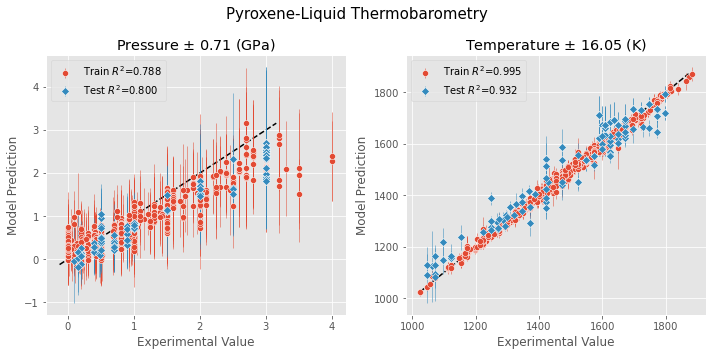

time: 1.66 s (started: 2021-12-31 18:31:27 +08:00)


In [272]:
fig, axis = plt.subplots(ncols=2, figsize=(10,5))

train_df = [df_P, df_T]
test_df = [df_P_test, df_T_test]
units = ['GPa', 'K']
titles = ['Pressure', 'Temperature']

for i, d, d_test, ax, title, unit in zip(range(2), train_df, test_df, axis.ravel(), titles, units):
    ax.plot([d['mean'].min(), d['mean'].max()], [d['mean'].min(), d['mean'].max()], 
            ls='--', c='k')
    
    xx = y_train_numpy[:,i]
    yy = d['mean']
    unc = d['std'].mean()
    
    r2 = metrics.r2_score(xx,yy)
    
    ax.errorbar(x=xx, y=yy, yerr=d['std'], 
                ls='', marker='o', mec='w', lw=0.5, mew=0.5, 
                label="Train $R^2$={:.3f}".format(r2))
    
    
    xx = y_test_numpy[:,i]
    yy = d_test['mean']
    
    
    r2 = metrics.r2_score(xx,yy)
    
    ax.errorbar(x=xx, y=yy, yerr=d_test['std'], 
                ls='', marker='D', mec='w', lw=0.5, mew=0.5, 
                label="Test $R^2$={:.3f}".format(r2))
        
    ax.set_title('{:} $\pm $ {:.2f} ({:})'.format(title, unc, unit))
    ax.set_xlabel('Experimental Value')
    ax.set_ylabel('Model Prediction')
    
    ax.legend(loc='upper left')
    
fig.suptitle('Pyroxene-Liquid Thermobarometry', fontsize=15)
    
fig.tight_layout()

for ext in ['png', 'svg', 'pdf']:
    fig.savefig('figures/results.{}'.format(ext))
    fig.savefig('figure-archives/results_{:}.{:}'.format(today, ext))

In [273]:
df_T_test['std'].describe()

count    119.000000
mean      43.921188
std       21.850079
min       13.353360
25%       25.823884
50%       37.850037
75%       56.267414
max      138.042984
Name: std, dtype: float64

time: 15 ms (started: 2021-12-31 19:08:48 +08:00)


In [274]:
df_T['std'].describe()

count    850.000000
mean      16.051355
std        6.523870
min        6.445966
25%       11.983865
50%       14.368809
75%       18.141107
max       79.906929
Name: std, dtype: float64

time: 0 ns (started: 2021-12-31 19:09:43 +08:00)


In [276]:
### Save Models Ensemble

for i in range(n_models):
    torch.save(models_tdict['{:}'.format(i)].state_dict, 'cpxliq_{:}.pt'.format(i))

time: 47 ms (started: 2021-12-31 19:40:48 +08:00)


## Visualize Neural Networks

In [372]:


def visualize_nn(model_summary, threshold = 20, ax=None, fig = None, annot = True):
    """
    model_summary: a touple (nodes number, activation func)
    ax: axis to plot on
    vert : place the network vertically with input on top
    """
    
    if ax==None : fig, ax = plt.subplots()

    ### make the nodes
    ax.invert_yaxis()
    for i, nodes in enumerate(model_summary):
        
        if nodes[0]>threshold:
            nodes_to_draw = nodes[0]/10
        else:
            nodes_to_draw = nodes[0]
            
        nodes_to_draw = int(nodes_to_draw)
            
        x_pos = [x - nodes_to_draw/2 for x in range(nodes_to_draw)]
        y_pos = [i for x in range(nodes_to_draw)]
    

        ax.scatter(x=x_pos, y = y_pos, fc='w', ec='k', zorder=2)
        
        ax.axis('off')

        if i>0:


            ### now connect the nodes

            node0 = model_summary[i-1]
            node1 = model_summary[i]
            
            n0 = int(node0[0])
            n1 =  int(node1[0])
            
            if (node0[0]>threshold):
                n0 = int(node0[0]/10)
            if (node1[0]>threshold):
                n1 =  int(node1[0]/10)
                
            y0 = [i-1 for x in range(n0)]
            y1 = [i for x in range(n1)]

            x0 = [x - n0/2 for x in range(n0)]
            x1 = [x - n1/2 for x in range(n1)]

            xx0, xx1 = np.meshgrid(x0,x1)
            xx0 = xx0.reshape(-1,1)
            xx1 =xx1.reshape(-1,1)
            XX = np.hstack((xx0,xx1))

            yy0, yy1 = np.meshgrid(y0,y1)
            yy0 = yy0.reshape(-1,1)
            yy1 =yy1.reshape(-1,1)
            YY = np.hstack((yy0,yy1))

            for x, y in zip(XX, YY):
                ax.plot(x,y, lw=0.2, zorder=0)
        if annot:
            ax.text(s = str(nodes[0]), x=-0.5, y = i, 
                    va = 'bottom', ha='center')
                
    if annot:
        ax.text(s = 'input', x=-0.5, y = -.20, ha='center')
        ax.text(s = 'output', x=-0.5, y = len(model_summary)-0.8, ha='center')
    

time: 0 ns (started: 2021-12-31 20:39:29 +08:00)


In [373]:
def get_model_summary(x):
    summary = [(25,'Relu')]
    
    for i in range(x[0]):
        summary.append((x[1], 'Relu'))
        
    summary.append((2,'relu'))
    
    return summary

time: 0 ns (started: 2021-12-31 20:39:29 +08:00)


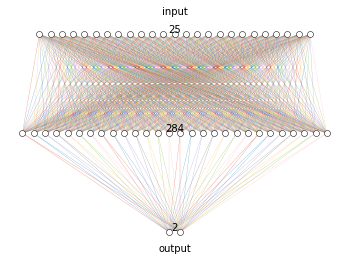

time: 594 ms (started: 2021-12-31 20:39:49 +08:00)


In [375]:
summary = get_model_summary(res_tdict[0].x)
visualize_nn(summary, annot=True, threshold=30)

In [294]:
summary

[(25, 'Relu'), (284, 'Relu'), (2, 'relu')]

time: 0 ns (started: 2021-12-31 19:58:18 +08:00)


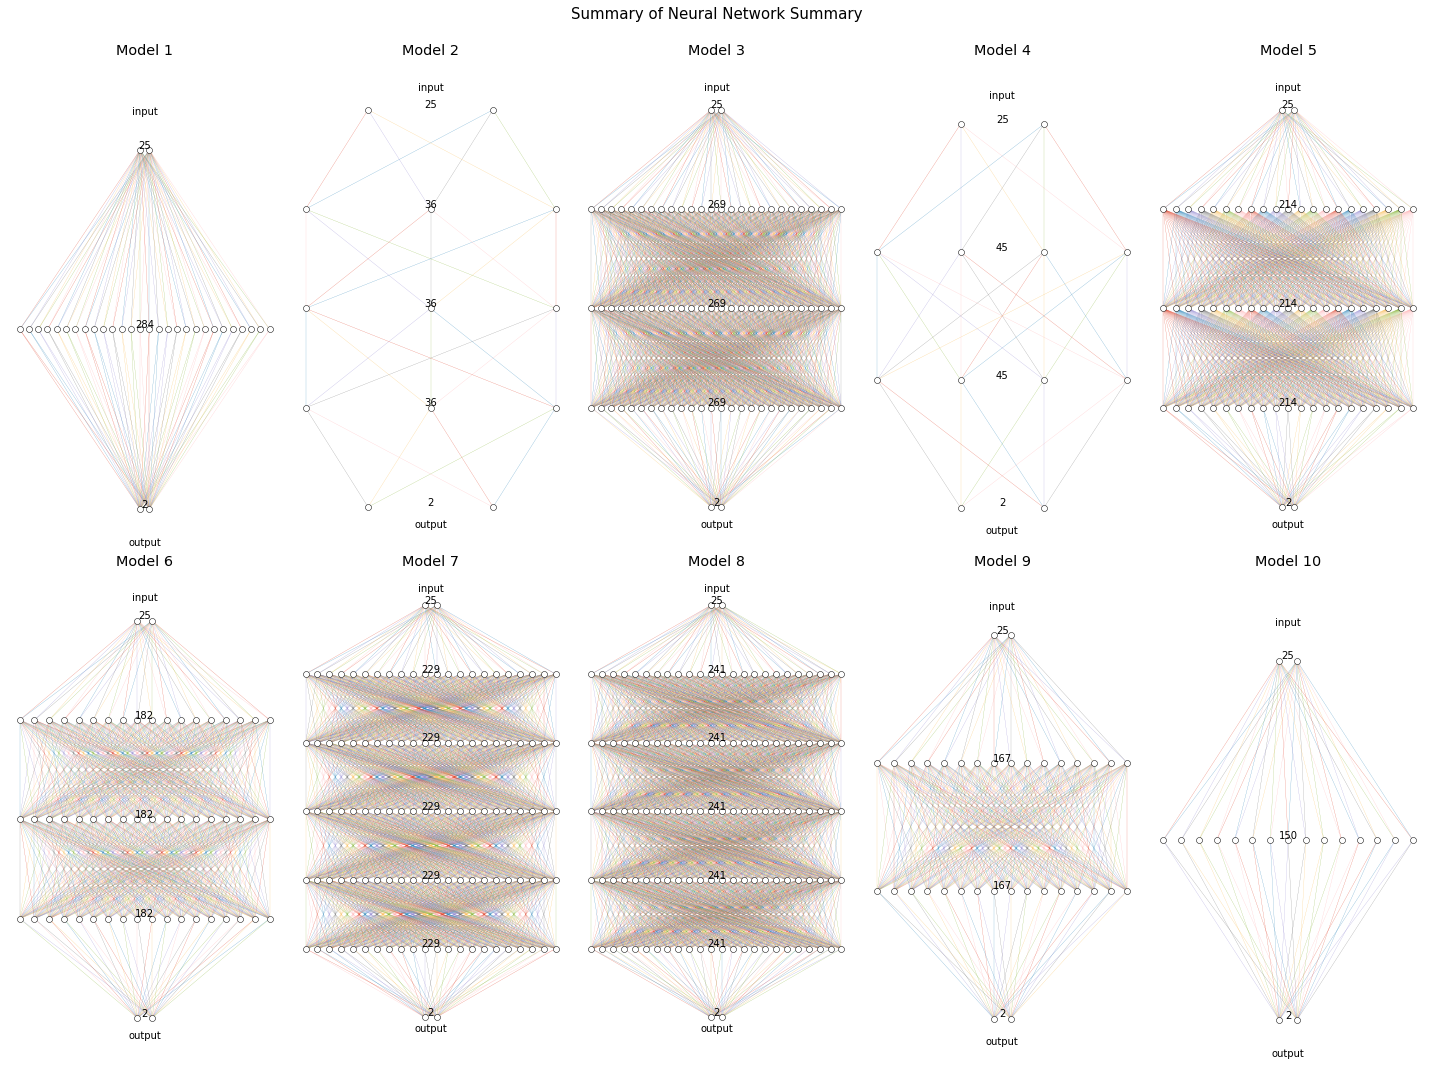

time: 14.5 s (started: 2021-12-31 20:57:55 +08:00)


In [388]:
fig, axis = plt.subplots(ncols=5, nrows=2, figsize=(20,15))

for i, ax in enumerate(axis.ravel()):
    summary = get_model_summary(res_tdict[i].x)
    visualize_nn(summary, ax=ax, threshold = 20)
    ax.set_title('Model {:}'.format(i+1))
    
    ax.set_ylim(top=-0.5)
    
fig.suptitle('Summary of Neural Network Summary', fontsize=15)    
fig.tight_layout(rect=(0,0,1,0.98))

for ext in ['png', 'pdf', 'svg']:
    fig.savefig('figures/nn-summary.{}'.format(ext))
    fig.savefig('figure-archives/nn-summary_{:}.{:}'.format(today,ext))
    


In [389]:
## save results
results =[df_T, df_P, df_T_test, df_P_test]
names = ['train_T', 'train_P', 'test_T', 'test_P']

for d, n in zip(results, names):
    d.to_excel('results/{:}.xlsx'.format(n))
    d.to_excel('result-archives/{:}_{:}.xlsx'.format(n, today))

time: 1.28 s (started: 2021-12-31 21:05:52 +08:00)
